In [1]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch 
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'torch {torch.__version__}')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from torch.utils.data import TensorDataset
import optuna
from torch import nn

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn import tree
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import f1_score

Package versions: 

numpy 1.23.5
pandas 1.5.3
scikit-learn 1.2.1
torch 2.0.0+cu117


C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\ericx\anaconda3\envs\QBUS2820\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value 

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


# Reading the data

In [2]:
bank = pd.read_csv('clean_bank.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)



train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='y']
X_valid = valid.loc[:, test.columns!='y']
X_test = test.loc[:, test.columns!='y']

# predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

# Encoding the data

In [3]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [4]:
binary = ['default','housing','loan','poutcome','contact']

variable = binary


dummies = pd.get_dummies(bank[variable])


binary_dummies = list(dummies.columns)

In [5]:
nominal = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for x in nominal:
    # Target encoder
    encoder = TargetEncoder().fit(train[x], y_train) # we must use the training set for this
    train[x+'TE'] = encoder.transform(train[x])
    valid[x+'TE'] = encoder.transform(valid[x])
    test[x+'TE'] = encoder.transform(test[x])


    # Leave one out encoder
    encoder = LeaveOneOutEncoder().fit(train[x], y_train) 
    train[x+'LeaveOneOut'] = encoder.transform(train[x])
    valid[x+'LeaveOneOut'] = encoder.transform(valid[x])
    test[x+'LeaveOneOut'] = encoder.transform(test[x])

    # GLMM encoder
    encoder =  GLMMEncoder().fit(train[x], y_train)
    train[x+'GLMM'] = encoder.transform(train[x])
    valid[x+'GLMM'] = encoder.transform(valid[x])
    test[x+'GLMM'] = encoder.transform(test[x])

    # CatBoostEncoder
    encoder = CatBoostEncoder().fit(train[x], y_train) 
    train[x+'CatBoost'] = encoder.transform(train[x])
    valid[x+'CatBoost'] = encoder.transform(valid[x])
    test[x+'CatBoost'] = encoder.transform(test[x])
    
    # One-hot encoder
    dummies = pd.get_dummies(bank[x],  prefix = x)
    train = train.join(dummies.loc[index_train, :])
    valid = valid.join(dummies.loc[index_valid, :])
    test = test.join(dummies.loc[index_test, :])
    globals()['%s_OneHot' % x] = list(dummies.columns)

In [6]:
keys = {
        'unknown' : 0,
        'basic4y' : 1, 
        'basic6y' : 2,
        'basic9y' : 3, 
        'highSchool' : 4, 
        'professional' : 5, 
        'university' : 6
}



variable = 'education'

train['educationOrdinal'] = train[variable].replace(keys).astype(int)
valid['educationOrdinal'] = valid[variable].replace(keys).astype(int)
test['educationOrdinal'] = test[variable].replace(keys).astype(int)

# Utilities

In [7]:
def plot_cm(labels, predictions):
    print(roc_auc_score(labels, predictions))
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))

In [8]:
def get_model_performance(algo, feature_list, algo_name):

  X_train = train[feature_list]
  X_test = test[feature_list]
  model = algo
  model.fit(X_train, y_train)

  # validation set predictions
  y_prob = np.zeros(len(y_test))
  y_prob = model.predict_proba(X_test)[:, 1]

  lfp = 1
  lfn = 19
  tau = lfp/(lfp+lfn)

  y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
  y_prob[y_prob > 1- 1e-5] =  1- 1e-5

  y_pred = (y_prob > tau).astype(int)
  # y_pred = model.predict(X_valid)
        
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

  columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'f1-score']

  results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

  results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
  results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
  results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
  results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
  results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
  results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
  results.iloc[:,6] =  f1_score(y_test, y_pred)  #f1-score
  return results, model

# Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
def get_feature_encodings(encoding_dic):
  best_features = []
  for i in encoding_dic:
    for j in encoding_dic[i]:
      if i == 'OneHot':
        best_features = best_features + globals()['%s_OneHot' % j]
      else:
        best_features = best_features + [j + i]
  return best_features

best_encodings_for_rf = {'OneHot': ['job', 'marital', 'default', 'loan', 'contact', 'month', 'poutcome'], 'LeaveOneOut': ['education', 'housing', 'day_of_week']}

best_features_for_rf = get_feature_encodings(best_encodings_for_rf)

features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_rf = best_features_for_rf + features

In [11]:
rf_params = {'criterion': 'entropy',
 'min_samples_leaf': 20,
 'max_features': 21,
 'max_depth': 7}

In [549]:
random_forest = RandomForestClassifier(**rf_params, n_estimators = 1000,
                                        random_state = 42)
results, random_forest = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Random Forest,0.28742,0.57862,0.80043,0.90741,0.35429,0.16247,0.27559


# Decision tree

In [12]:
best_encodings_for_dt = {'OneHot': ['job', 'education', 'default', 'poutcome'], 'LeaveOneOut': ['marital', 'housing', 'loan', 'contact', 'month', 'day_of_week']}
best_features_for_dt = get_feature_encodings(best_encodings_for_dt)
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_dt = best_features_for_dt + features

In [13]:
dt_params = {'criterion': 'entropy', 'min_samples_leaf': 40, 'max_features': 28}

In [144]:
decision_tree = tree.DecisionTreeClassifier(random_state=42, **dt_params)
results, decision_tree = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Decision Tree,0.35589,0.47727,0.77939,0.83333,0.47986,0.1811,0.29754


# KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train[feature_for_rf], y_train)

KNeighborsClassifier(n_neighbors=3)

In [147]:
results, decision_tree = get_model_performance(knn, feature_for_rf, "knn")
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
knn,0.8272,0.26649,0.68999,0.57704,0.75511,0.24543,0.34439


(True Negatives):  3460
(False Positives):  1089
(False Negatives):  286
(True Positives):  359
Total subscribed Transactions:  645


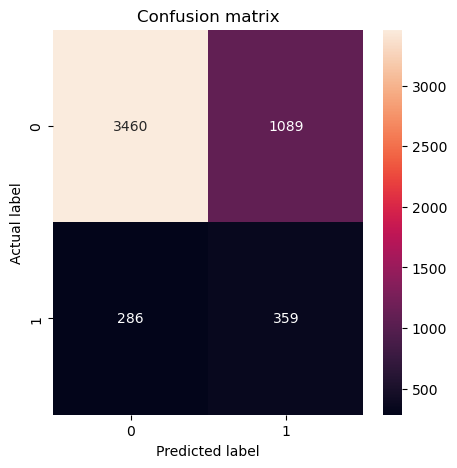

In [148]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = knn.predict_proba(valid[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

# Bagging

In [16]:
from sklearn.ensemble import BaggingClassifier

In [17]:
bag_params = {'n_estimators': 194, 'max_samples': 1660, 'max_features': 5}

In [18]:
best_encodings_for_bag = {'OneHot': ['marital', 'default', 'loan', 'contact', 'poutcome'], 'TE': ['education', 'month'], 'GLMM': ['job', 'housing', 'day_of_week'], 'LeaveOneOut': ['education', 'housing']}

best_features_for_bag = get_feature_encodings(best_encodings_for_bag)

features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_bag = best_features_for_bag + features

In [152]:
tuned_bag = BaggingClassifier(**params, random_state=42)

results, fitted_model = get_model_performance(tuned_bag, feature_for_bag, "Bagging")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
Bagging,0.29847,0.78535,0.79225,0.96815,0.11063,0.13063,0.23021


# XGBoost

In [19]:
import xgboost as xgb

xgBoost_features = features  + ['jobCatBoost','maritalCatBoost'] + education_OneHot + month_OneHot + day_of_week_OneHot + binary_dummies 

xgb_X_train = train[xgBoost_features].copy()
xgb_X_valid = valid[xgBoost_features].copy()
xgb_X_test = test[xgBoost_features].copy()



# Assuming your features are stored in 'X' and labels in 'y'
xgb_train_data = xgb.DMatrix(xgb_X_train, label=y_train)
xgb_valid_data = xgb.DMatrix(xgb_X_valid, label=y_valid)
xgb_test_data = xgb.DMatrix(xgb_X_test, label=y_test)

In [20]:
xgb_params = {'objective': 'binary:logistic',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 6,
                'lambda_l1': 0.10453678278574731,
                'lambda_l2': 8.824357269705966e-05,
                'bagging_fraction': 0.8617325889154706,
                'bagging_freq': 10,
                'feature_fraction': 0.7692479352052168,
                'min_data_in_leaf': 65,
                'feature_pre_filter': False,
                'verbosity': 0}

best_xgbst = xgb.train(xgb_params, xgb_train_data, num_boost_round=1000)

In [155]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['XGBoost - Valid']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_xgbst]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(xgb_valid_data)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
XGBoost - Valid,0.111,0.234,0.982,0.645,0.782,0.298,0.344


# Gradient Boost

In [21]:


train1_v = bank.loc[index_train_v, :].copy()
test1 = bank.loc[index_test, :].copy()


train1_v = train1_v.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','pdays','previous','poutcome'], axis=1).copy()


test1 = test1.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','pdays','previous','poutcome'], axis=1).copy()



index_train1, index_valid1 = train_test_split(train1_v.index, train_size=0.8, random_state=7)

train1 = train1_v.loc[index_train1, :].copy()
valid1 = train1_v.loc[index_valid1, :].copy()



X_train1 = train1.loc[:, train1.columns!='y']
X_valid1 = valid1.loc[:, valid1.columns!='y']
X_test1 = test1.loc[:, test1.columns!='y']

predictors1 = list(X_train1.columns)


y_train1 = train1['y']
y_valid1 = valid1['y']
y_test1 = test1['y']

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, n_estimators= 1901, subsample = 0.596)
gb.fit(X_train1, y_train1)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1901,
                           subsample=0.596)

# Histogram Boost

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, max_iter = 1901)

hgb.fit(X_train1, y_train1)

HistGradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_iter=1901)

# CatBoost

In [24]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0
                      )
        
cb.fit(X_train1, y_train1)

# LightGBM

In [25]:
import lightgbm as lgb

lgbm_params = { 'objective': 'binary',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 44,
                'lambda_l1': 2.3940244060036417,
                'lambda_l2': 8.243998317794096e-08,
                'bagging_fraction': 0.7165092950708541,
                'bagging_freq': 3,
                'feature_fraction': 0.5253096835972446,
                'min_data_in_leaf': 17,
                'feature_pre_filter': False,
                'verbosity': -1}

In [26]:
import lightgbm as lgb

lightGBM_features_2nd = features  + ['educationOrdinal', 
                                     'maritalGLMM', 
                                     'day_of_weekCatBoost'] + job_OneHot + month_OneHot + binary_dummies 

lgbm_X_train_2nd = train[lightGBM_features_2nd].copy()
lgbm_X_valid_2nd = valid[lightGBM_features_2nd].copy()
lgbm_X_test_2nd = test[lightGBM_features_2nd].copy()



lgbm_train_data_2nd = lgb.Dataset(lgbm_X_train_2nd, y_train)
lgbm_valid_data_2nd = lgb.Dataset(lgbm_X_valid_2nd, y_valid, reference = lgbm_train_data_2nd)
lgbm_test_data_2nd = lgb.Dataset(lgbm_X_test_2nd, y_test, reference = lgbm_train_data_2nd)

In [27]:
lgbm = lgb.train(lgbm_params, lgbm_train_data_2nd, num_boost_round=1000)

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['Best - LightBoost - Valid 1', 'Best - LightBoost - Valid 2']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(lgbm_X_valid_2nd)
    y_pred = [1 if x >= 1/20 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

NameError: name 'lgbm' is not defined

# Logistic regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000).fit(X_train1, y_train1)

In [30]:
results, logistic_regression = get_model_performance(logistic_regression, X_train1.columns, "logistic regression")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,f1-score
logistic regression,0.31444,0.55283,0.73527,0.80889,0.39724,0.15629,0.26196


# Super learner

In [31]:
from sklearn.model_selection import KFold
from numpy import hstack
from numpy import vstack
from numpy import asarray

In [32]:
class SuperLearner:
    
    def __init__(self, num_folds, model_features):
        self.num_folds = num_folds
        self.models = {}
        self.tau = 1/20
        self.model_features = model_features
        
    def add_model(self, model, name):
        self.models[name] = model
        
    def add_meta_model(self, model):
        self.meta_model = model
    
    # X is just the full dataset with all the encodings
    def fit_base_models(self, X, y, lgbm_params, xgb_params):
        for model in self.models:
            features = self.model_features[model]
            print(f'training features: {model}, shape: {X[features].shape}, {features}')
            if model == 'lgbm':
                lgbm_X_train_2nd = train[features].copy()
                lgbm_train_data_2nd = lgb.Dataset(lgbm_X_train_2nd, y_train)

                self.models[model] = self.models[model].train(lgbm_params, lgbm_train_data_2nd, num_boost_round=1000)
            elif model == 'xgb':
                xgb_X_train = train[features].copy()
                xgb_train_data = xgb.DMatrix(xgb_X_train, label=y_train)
                self.models[model] = self.models[model].train(xgb_params, xgb_train_data, num_boost_round=1000)
            else:
                self.models[model].fit(X[features], y)
    
    def fit_meta_model(self, meta_x, meta_y):
        self.meta = self.meta_model.fit(meta_x, meta_y)
        
    def get_out_of_fold_predictions(self, X, y):
        meta_x, meta_y = list(), list()
        
        kfolds = KFold(n_splits=self.num_folds, shuffle=True)
        
        for train_ix, test_ix in kfolds.split(X):
            print(train_ix)
            folds_yhats = list()
            train_x, test_x = X.iloc[train_ix], X.iloc[test_ix]
            train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
            meta_y.extend(test_y)
            
            for model in self.models:

                features = self.model_features[model]
                y_hat = None

                if model == 'lgbm':
    
                    lgbm_X_train = train_x[features].copy()
                    lgbm_X_test = test_x[features].copy()
            
                    lgbm_train_data = lgb.Dataset(lgbm_X_train, train_y)
                    lgbm_test_data = lgb.Dataset(lgbm_X_test, test_y, reference = lgbm_train_data_2nd)
                    
                    booster = lgb.train(lgbm_params, lgbm_train_data, num_boost_round=1000)
                    
                    y_hat = booster.predict(test_x[features])
                    
                elif model == 'xgb':
                    xgb_X_train = train_x[features].copy()
                    xgb_train_data = xgb.DMatrix(xgb_X_train, label=train_y)
                    booster = xgb.train(xgb_params, xgb_train_data, num_boost_round=1000)

                    xgb_X_test = test_x[features].copy()
                    xgb_test_data = xgb.DMatrix(xgb_X_test)
                    y_hat = booster.predict(xgb_test_data)
                    
                else:
                    self.models[model].fit(train_x[features], train_y)
                    y_hat = self.models[model].predict_proba(test_x[features])
                    y_hat = y_hat[:, 1]
                
                folds_yhats.append(y_hat.reshape(len(y_hat),1))
                
                
#                 print(len(y_hat))
            meta_x.append(hstack(folds_yhats))
            
        self.meta_x = vstack(meta_x)
        self.meta_y = asarray(meta_y)
        return self.meta_x, self.meta_y
        
    def evaluate_models(self, X_valid, y_valid):
        for model in self.models:
            features = self.model_features[model]
            y_prob = 0
            if "lgbm" == model:
                y_prob = self.models[model].predict(X_valid[features])
                
            elif "xgb" == model:
                xgb_X_test = X_valid[features].copy()
                xgb_test_data = xgb.DMatrix(xgb_X_test)
                y_prob = self.models[model].predict(xgb_test_data)
                
            else:
                y_prob = self.models[model].predict_proba(X_valid[features])[:, 1]
                
            print(model)
            y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
            y_prob[y_prob > 1- 1e-5] =  1- 1e-5
            print(roc_auc_score(y_valid, y_prob))
                
    def super_learner_predict(self, X):
        meta_x = list()
        
        for model in self.models:
            print(model)
            features = self.model_features[model]
            print(features)
            yhat = None
            if "lgbm" == model:
                yhat = self.models[model].predict(X[features])
                
            elif 'xgb' == model:
                xgb_X_test = X[features].copy()
                xgb_test_data = xgb.DMatrix(xgb_X_test)
                yhat = self.models[model].predict(xgb_test_data)
                
            else:
                yhat = self.models[model].predict_proba(X[features])[:, 1]
            
            meta_x.append(yhat.reshape(len(yhat),1))
        meta_x = hstack(meta_x)
            
        return self.meta_model.predict_proba(meta_x), self.meta_model.predict(meta_x)

In [33]:
continuous = ['age', 'emp_var_rate','cons_price_idx',
              'cons_conf_idx','euribor_3m','nr_employed']

for x in continuous:

    if train[x].min() > 0:
        # Log
        train[x+'Log'] = np.log(train[x])
        valid[x+'Log'] = np.log(valid[x])
        test[x+'Log'] = np.log(test[x])

In [34]:
logit_con = ['age','emp_var_rate', 'cons_price_idxLog','cons_conf_idx','euribor_3mLog','nr_employedLog']
logit_cat = month_OneHot + ['jobGLMM','maritalGLMM','educationGLMM','day_of_weekGLMM']


logit_predictors = binary_dummies + ['previous'] + logit_cat + logit_con
model_features = {'rf': feature_for_rf, 'rf_uo': feature_for_rf, 'dt_uo': feature_for_dt, 'dt': feature_for_dt, 
                  'bag': feature_for_bag, 'bag_uo': feature_for_bag, 'gb': X_train1.columns, 
                  'hb': X_train1.columns, 'cb': X_train1.columns, 'lgbm': lightGBM_features_2nd, 'lr': logit_predictors, 
                 'xgb': xgBoost_features, 'default': X_train1.columns}


In [742]:

sp = SuperLearner(2, model_features)

In [35]:
#uo stands for unoptimised

models = {'rf': RandomForestClassifier(random_state=42, **rf_params, n_estimators = 1000),
          'rf_uo': RandomForestClassifier(random_state=42, n_estimators = 1000),
          'dt': tree.DecisionTreeClassifier(random_state=42, **dt_params),
          'dt_uo': tree.DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42, **bag_params),
          'bag_uo': BaggingClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'hb': HistGradientBoostingClassifier(random_state=42),
          'cb': CatBoostClassifier(random_state=42, loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0),
          'lgbm': lgb,
          'lr': LogisticRegression(random_state=42, max_iter=1000),
          'xgb': xgb
         }


In [ ]:

for i in models:
    sp.add_model(models[i], i)

In [744]:
X_train1.columns

Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')

In [745]:
meta_X, meta_y = sp.get_out_of_fold_predictions(train, y_train)

[    0     1     2 ... 20769 20770 20772]
[    3     4     5 ... 20771 20773 20774]


In [746]:
print('Meta ', meta_X.shape, meta_y.shape)

Meta  (20775, 12) (20775,)


In [747]:
sp.fit_base_models(train, y_train, lgbm_params, xgb_params)


training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', '

In [748]:
sp.evaluate_models(test, y_test)

rf
0.8004336514428538
rf_uo
0.7493019768234492
dt
0.7793887374081647
dt_uo
0.6109854578504884
bag
0.7922528970688479
bag_uo
0.7231579186548512
gb
0.7908928273877147
hb
0.789529235779747
cb
0.7890129137317277
lgbm
0.80113224267212
lr
0.7901606453078847
xgb
0.7987263122017723


In [749]:
sp.add_meta_model(LogisticRegression(random_state=42, max_iter=1000))
sp.fit_meta_model(meta_X, meta_y)

In [750]:
y_prob, y_pred = sp.super_learner_predict(test)

rf
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown',

0.3593329747175901
0.5173097023403772
(True Negatives):  440
(False Positives):  9340
(False Negatives):  14
(True Positives):  1336
Total subscribed Transactions:  1350


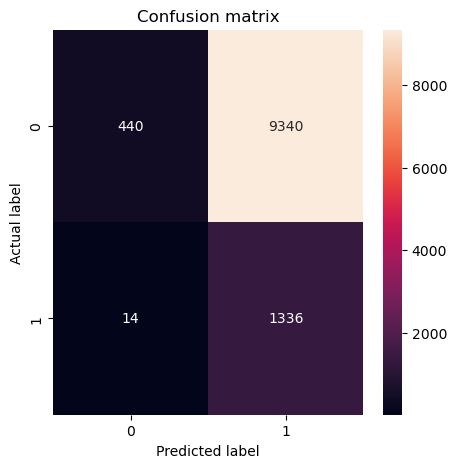

In [751]:
print(f1_score(y_test, y_pred))
y_prob = y_prob[:, -1]
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)

In [571]:

print(y_prob)

[0.49850965 0.06441789 0.05633458 ... 0.06558261 0.05602643 0.05140344]


0.571657577823222
(True Negatives):  1887
(False Positives):  7893
(False Negatives):  67
(True Positives):  1283
Total subscribed Transactions:  1350


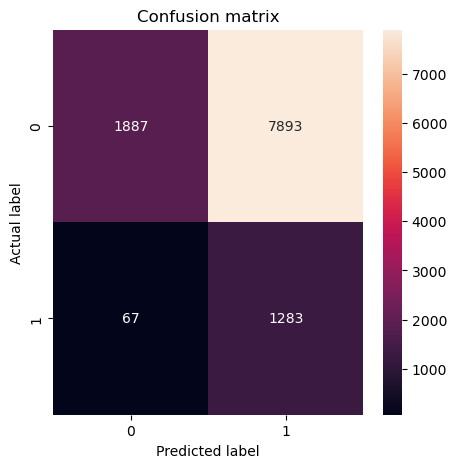

In [465]:
tau = 1/19
y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)

In [471]:
print(models.keys())

dict_keys(['rf', 'rf_uo', 'dt', 'dt_uo', 'bag', 'bag_uo', 'gb', 'hb', 'cb', 'lgbm', 'lr', 'xgb'])


# Optimising using optuna

In [36]:
from sklearn.base import clone

In [713]:
def create_model(trial):
    models = {'rf': RandomForestClassifier(random_state=42, **rf_params, n_estimators = 1000),
          'rf_uo': RandomForestClassifier(random_state=42, n_estimators = 1000),
          'dt': tree.DecisionTreeClassifier(random_state=42, **dt_params),
          'dt_uo': tree.DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42, **bag_params),
          'bag_uo': BaggingClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'hb': HistGradientBoostingClassifier(random_state=42),
          'cb': CatBoostClassifier(random_state=42, loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0),
          'lgbm': lgb,
          'lr': LogisticRegression(random_state=42, max_iter=1000),
          'xgb': xgb
         }

    models_chosen = {}
    
    model_names = ['rf', 'rf_uo', 'dt', 'dt_uo', 'bag', 'bag_uo', 'gb', 'hb', 'cb', 'lgbm', 'lr', 'xgb']
    
    meta_model = ['rf', 'rf_uo', 'dt', 'dt_uo', 'gb', 'hb', 'cb', 'lr']
    
    n_models = trial.suggest_int("n_models", 2, 12)
    
    for i in range(n_models):
        model_item = trial.suggest_categorical('model_{}'.format(i), model_names)
        if model_item not in models_chosen:
            if model_item == 'lgbm' or model_item == 'xgb':
                models_chosen[model_item] = models[model_item]
            else:
                models_chosen[model_item] = clone(models[model_item])
                
    folds = trial.suggest_int("folds", 2, 6)
    model = SuperLearner(folds, model_features)
    
    for i in models_chosen:
        model.add_model(models_chosen[i], i)
        
    head = trial.suggest_categorical('head', meta_model)
    
    model.add_meta_model(models[head])
    
    return model





In [714]:
def objective(trial):
    model = create_model(trial)
    
    meta_X, meta_y = model.get_out_of_fold_predictions(train, y_train)
    model.fit_base_models(train, y_train, lgbm_params, xgb_params)
    model.fit_meta_model(meta_X, meta_y)
    y_prob, y_pred = model.super_learner_predict(test)
    
    f1 = f1_score(y_test, y_pred)
    return f1

In [715]:
train.shape

(20775, 116)

In [716]:
test[['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']]

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,monthLeaveOneOut,day_of_weekLeaveOneOut,age,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
35911,0,0,0,0,0,0,0,0,0,0,...,0.107406,0.125713,34,999,0,-1.7,94.055,-39.8,0.761,4991.6
18526,0,0,0,0,0,0,0,0,0,1,...,0.128482,0.126313,44,999,0,1.4,93.444,-36.1,4.965,5228.1
7703,1,0,0,0,0,0,0,0,0,0,...,0.107406,0.125713,52,999,0,1.4,94.465,-41.8,4.864,5228.1
13392,0,0,0,0,1,0,0,0,0,0,...,0.098158,0.125713,34,999,0,1.4,93.918,-42.7,4.961,5228.1
31273,0,1,0,0,0,0,0,0,0,0,...,0.070915,0.115885,57,999,0,-1.8,92.893,-46.2,1.250,5099.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7307,0,1,0,0,0,0,0,0,0,0,...,0.107406,0.112873,49,999,0,1.4,94.465,-41.8,4.865,5228.1
15509,0,1,0,0,0,0,0,0,0,0,...,0.098158,0.115885,47,999,0,1.4,93.918,-42.7,4.962,5228.1
28354,0,1,0,0,0,0,0,0,0,0,...,0.070915,0.134095,35,999,0,-1.8,92.893,-46.2,1.327,5099.1
9121,0,0,1,0,0,0,0,0,0,0,...,0.107406,0.126313,39,999,0,1.4,94.465,-41.8,4.959,5228.1


In [717]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, timeout=50000)

[I 2023-05-22 21:42:53,643] A new study created in memory with name: no-name-d47ccb26-5f49-4f3c-a275-2cd457c01ff9


[    0     4     5 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object'

[I 2023-05-22 21:53:48,539] Trial 0 finished with value: 0.29714285714285715 and parameters: {'n_models': 6, 'model_0': 'lr', 'model_1': 'hb', 'model_2': 'lgbm', 'model_3': 'gb', 'model_4': 'rf_uo', 'model_5': 'cb', 'folds': 6, 'head': 'cb'}. Best is trial 0 with value: 0.29714285714285715.


[    3     5     6 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20770 20771 20773]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed

[I 2023-05-22 21:56:46,706] Trial 1 finished with value: 0.28 and parameters: {'n_models': 5, 'model_0': 'bag_uo', 'model_1': 'lgbm', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'cb', 'folds': 3, 'head': 'cb'}. Best is trial 0 with value: 0.29714285714285715.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    2     3     4 ... 20771 20772 20773]
[    0     1     2 ... 20768 20770 20774]
[    0     1     4 ... 20772 20773 20774]
training features: rf_uo, sh

[I 2023-05-22 21:59:09,095] Trial 2 finished with value: 0.2973905840121497 and parameters: {'n_models': 3, 'model_0': 'rf_uo', 'model_1': 'rf', 'model_2': 'rf_uo', 'folds': 3, 'head': 'dt'}. Best is trial 2 with value: 0.2973905840121497.


[    0     1     2 ... 20771 20772 20774]
[    1     2     3 ... 20771 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     2     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-22 22:04:58,177] Trial 3 finished with value: 0.28503899787284326 and parameters: {'n_models': 11, 'model_0': 'bag', 'model_1': 'cb', 'model_2': 'dt_uo', 'model_3': 'gb', 'model_4': 'rf', 'model_5': 'dt', 'model_6': 'dt', 'model_7': 'lgbm', 'model_8': 'lr', 'model_9': 'gb', 'model_10': 'bag_uo', 'folds': 5, 'head': 'gb'}. Best is trial 2 with value: 0.2973905840121497.


[    0     1     2 ... 20772 20773 20774]
[    0     2     4 ... 20769 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    1     3     5 ... 20771 20772 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y'

[I 2023-05-22 22:08:22,671] Trial 4 finished with value: 0.281291251650066 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'xgb', 'model_2': 'rf_uo', 'model_3': 'gb', 'model_4': 'rf_uo', 'model_5': 'xgb', 'model_6': 'hb', 'folds': 4, 'head': 'rf_uo'}. Best is trial 2 with value: 0.2973905840121497.


[    2     4     5 ... 20770 20771 20772]
[    0     1     3 ... 20769 20773 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')


[I 2023-05-22 22:08:26,380] Trial 5 finished with value: 0.26420633256447895 and parameters: {'n_models': 2, 'model_0': 'gb', 'model_1': 'gb', 'folds': 2, 'head': 'gb'}. Best is trial 2 with value: 0.2973905840121497.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    1     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     4 ... 20770 20771 20772]
[    0     1     2 ... 20770 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basi

[I 2023-05-22 22:08:59,424] Trial 6 finished with value: 0.2704485488126649 and parameters: {'n_models': 4, 'model_0': 'gb', 'model_1': 'hb', 'model_2': 'gb', 'model_3': 'dt_uo', 'folds': 6, 'head': 'rf'}. Best is trial 2 with value: 0.2973905840121497.


[    0     1     2 ... 20768 20769 20770]
[    3     5     6 ... 20772 20773 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', '

[I 2023-05-22 22:10:09,740] Trial 7 finished with value: 0.2702582862210398 and parameters: {'n_models': 6, 'model_0': 'bag', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'bag_uo', 'model_4': 'gb', 'model_5': 'hb', 'folds': 2, 'head': 'hb'}. Best is trial 2 with value: 0.2973905840121497.


[    0     1     4 ... 20770 20772 20773]
[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20769 20771 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_ma

[I 2023-05-22 22:12:26,724] Trial 8 finished with value: 0.29495332160736026 and parameters: {'n_models': 7, 'model_0': 'gb', 'model_1': 'lr', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'gb', 'model_6': 'dt_uo', 'folds': 3, 'head': 'rf_uo'}. Best is trial 2 with value: 0.2973905840121497.


[    0     1     2 ... 20770 20771 20774]
[    0     1     2 ... 20770 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    1     4     5 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-22 22:17:42,848] Trial 9 finished with value: 0.3200574094007894 and parameters: {'n_models': 5, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'rf', 'folds': 5, 'head': 'dt_uo'}. Best is trial 9 with value: 0.3200574094007894.


[    0     1     2 ... 20771 20772 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     4 ... 20767 20768 20773]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-22 22:23:33,808] Trial 10 finished with value: 0.3039073806078147 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'lr', 'model_5': 'rf', 'model_6': 'bag', 'model_7': 'lr', 'model_8': 'rf', 'model_9': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 9 with value: 0.3200574094007894.


[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20771 20773 20774]
[    1     2     5 ... 20772 20773 20774]
[    0     1     3 ... 20770 20772 20773]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-22 22:28:49,167] Trial 11 finished with value: 0.32568306010928966 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'lr', 'model_5': 'rf', 'model_6': 'bag', 'model_7': 'lr', 'model_8': 'rf', 'model_9': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 11 with value: 0.32568306010928966.


[    0     1     2 ... 20770 20771 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
[    1     3     4 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-22 22:33:08,330] Trial 12 finished with value: 0.33603953406283094 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag_uo', 'model_7': 'gb', 'model_8': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20770 20771 20772]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     3     4 ... 20768 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', '

[I 2023-05-22 22:36:32,263] Trial 13 finished with value: 0.3073065902578796 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'hb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag_uo', 'model_7': 'gb', 'model_8': 'bag', 'model_9': 'hb', 'folds': 4, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20769 20773 20774]
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOu

[I 2023-05-22 22:38:38,488] Trial 14 finished with value: 0.22382550335570472 and parameters: {'n_models': 9, 'model_0': 'hb', 'model_1': 'dt_uo', 'model_2': 'bag', 'model_3': 'lgbm', 'model_4': 'bag_uo', 'model_5': 'rf', 'model_6': 'bag_uo', 'model_7': 'gb', 'model_8': 'bag', 'folds': 5, 'head': 'lr'}. Best is trial 12 with value: 0.33603953406283094.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     2 ... 20770 20771 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     4 ... 20772 20773 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'ho

[I 2023-05-22 22:43:23,977] Trial 15 finished with value: 0.3215258855585831 and parameters: {'n_models': 12, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'dt', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    2     4     6 ... 20771 20772 20773]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20769

[I 2023-05-22 22:45:05,865] Trial 16 finished with value: 0.3120057512580877 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'bag', 'model_2': 'rf', 'model_3': 'bag', 'model_4': 'lr', 'model_5': 'lgbm', 'model_6': 'gb', 'model_7': 'lr', 'model_8': 'rf', 'folds': 4, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    1     4     6 ... 20769 20772 20774]
[    0     1     2 ... 20771 20773 20774]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_

[I 2023-05-22 22:54:47,130] Trial 17 finished with value: 0.3146235593474031 and parameters: {'n_models': 9, 'model_0': 'rf', 'model_1': 'dt', 'model_2': 'hb', 'model_3': 'rf_uo', 'model_4': 'xgb', 'model_5': 'rf_uo', 'model_6': 'xgb', 'model_7': 'cb', 'model_8': 'bag_uo', 'folds': 5, 'head': 'dt'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     4 ... 20770 20771 20772]
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays',

[I 2023-05-22 23:00:31,201] Trial 18 finished with value: 0.28124638016911846 and parameters: {'n_models': 12, 'model_0': 'cb', 'model_1': 'dt', 'model_2': 'lr', 'model_3': 'lr', 'model_4': 'lgbm', 'model_5': 'lr', 'model_6': 'rf', 'model_7': 'bag_uo', 'model_8': 'dt_uo', 'model_9': 'dt', 'model_10': 'gb', 'model_11': 'gb', 'folds': 4, 'head': 'rf'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20770 20772 20773]
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', '

[I 2023-05-22 23:04:10,357] Trial 19 finished with value: 0.22846734322144155 and parameters: {'n_models': 8, 'model_0': 'dt_uo', 'model_1': 'dt_uo', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'hb', 'model_5': 'bag', 'model_6': 'lgbm', 'model_7': 'rf_uo', 'folds': 6, 'head': 'lr'}. Best is trial 12 with value: 0.33603953406283094.


[    1     2     4 ... 20771 20773 20774]
[    0     1     2 ... 20769 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20774]
[    0     1     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lr, shape: (

rf
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
   

[I 2023-05-22 23:13:18,377] Trial 20 finished with value: 0.28086997193638913 and parameters: {'n_models': 11, 'model_0': 'dt', 'model_1': 'lr', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'dt', 'model_5': 'dt_uo', 'model_6': 'rf_uo', 'model_7': 'rf', 'model_8': 'gb', 'model_9': 'cb', 'model_10': 'hb', 'folds': 5, 'head': 'hb'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20771 20772 20774]
[    0     1     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20773]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',

[I 2023-05-22 23:18:02,744] Trial 21 finished with value: 0.31258941344778257 and parameters: {'n_models': 12, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'bag_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'xgb', 'model_10': 'dt', 'model_11': 'dt', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20771 20773 20774]
[    0     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771

rf
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-22 23:29:11,986] Trial 22 finished with value: 0.3173323561744229 and parameters: {'n_models': 11, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'cb', 'model_7': 'dt', 'model_8': 'rf_uo', 'model_9': 'xgb', 'model_10': 'rf', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20768 20770 20773]
[    1     2     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', '

[I 2023-05-22 23:30:13,466] Trial 23 finished with value: 0.31810131066241587 and parameters: {'n_models': 10, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'lgbm', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'xgb', 'model_8': 'hb', 'model_9': 'dt_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20769 20771 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     5     6 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOu

[I 2023-05-22 23:37:16,419] Trial 24 finished with value: 0.3107626514611546 and parameters: {'n_models': 12, 'model_0': 'dt', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'rf', 'model_6': 'lr', 'model_7': 'hb', 'model_8': 'xgb', 'model_9': 'bag', 'model_10': 'lr', 'model_11': 'hb', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    1     2     3 ... 20770 20772 20773]
[    0     2     3 ... 20771 20772 20774]
[    0     1     3 ... 20772 20773 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y',

[I 2023-05-22 23:38:43,593] Trial 25 finished with value: 0.32219486457966934 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'bag', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    1     3     5 ... 20771 20772 20774]
[    0     1     2 ... 20771 20772 20773]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y',

[I 2023-05-22 23:39:55,121] Trial 26 finished with value: 0.30279448178280866 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'bag', 'model_6': 'bag_uo', 'model_7': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20769 20771 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20772 20773 20774]
[    1     2     3 ... 20771 20772 20773]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y',

[I 2023-05-22 23:41:03,592] Trial 27 finished with value: 0.321830985915493 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'bag', 'model_7': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    1     2     3 ... 20771 20772 20773]
[    0     1     2 ... 20769 20773 20774]
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', '

[I 2023-05-22 23:43:56,479] Trial 28 finished with value: 0.28862275449101793 and parameters: {'n_models': 7, 'model_0': 'dt_uo', 'model_1': 'bag', 'model_2': 'rf', 'model_3': 'dt_uo', 'model_4': 'lr', 'model_5': 'lgbm', 'model_6': 'lr', 'folds': 6, 'head': 'cb'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20772 20773 20774]
[    0     2     4 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    1     2     3 ... 20771 20772 20773]
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', '

[I 2023-05-22 23:49:11,469] Trial 29 finished with value: 0.27747378020975827 and parameters: {'n_models': 9, 'model_0': 'cb', 'model_1': 'lgbm', 'model_2': 'dt', 'model_3': 'lr', 'model_4': 'hb', 'model_5': 'dt', 'model_6': 'dt_uo', 'model_7': 'dt_uo', 'model_8': 'cb', 'folds': 6, 'head': 'rf'}. Best is trial 12 with value: 0.33603953406283094.


[    1     2     4 ... 20771 20772 20773]
[    0     1     2 ... 20770 20771 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
t

[I 2023-05-22 23:51:39,372] Trial 30 finished with value: 0.28363465602254057 and parameters: {'n_models': 6, 'model_0': 'rf_uo', 'model_1': 'gb', 'model_2': 'lgbm', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'xgb', 'folds': 4, 'head': 'gb'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20772 20773 20774]
[    1     2     4 ... 20769 20770 20771]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y',

[I 2023-05-22 23:52:47,664] Trial 31 finished with value: 0.31885098743267504 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'bag', 'model_7': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    2     3     5 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20770 20772 20773]
[    0     1     2 ... 20771 20772 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_profes

[I 2023-05-22 23:54:14,816] Trial 32 finished with value: 0.28669915606799 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'hb', 'model_6': 'bag', 'model_7': 'bag', 'folds': 4, 'head': 'cb'}. Best is trial 12 with value: 0.33603953406283094.


[    1     2     3 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20770 20772 20774]
[    0     1     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y',

[I 2023-05-22 23:55:20,943] Trial 33 finished with value: 0.3168247277836319 and parameters: {'n_models': 10, 'model_0': 'bag_uo', 'model_1': 'xgb', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'bag_uo', 'model_6': 'bag', 'model_7': 'bag', 'model_8': 'lgbm', 'model_9': 'bag_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20767 20768 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknow

[I 2023-05-23 00:02:49,214] Trial 34 finished with value: 0.3086892488954345 and parameters: {'n_models': 7, 'model_0': 'bag_uo', 'model_1': 'rf_uo', 'model_2': 'lgbm', 'model_3': 'dt', 'model_4': 'gb', 'model_5': 'cb', 'model_6': 'dt', 'folds': 5, 'head': 'dt'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     4 ... 20769 20771 20772]
[    0     2     3 ... 20771 20773 20774]
[    1     2     3 ... 20772 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'de

[I 2023-05-23 00:05:13,045] Trial 35 finished with value: 0.32129342965256275 and parameters: {'n_models': 9, 'model_0': 'lr', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'bag', 'model_4': 'cb', 'model_5': 'lr', 'model_6': 'gb', 'model_7': 'gb', 'model_8': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    1     2     5 ... 20772 20773 20774]
[    0     1     2 ... 20768 20770 20771]
[    0     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of

[I 2023-05-23 00:10:11,107] Trial 36 finished with value: 0.2917987070604639 and parameters: {'n_models': 8, 'model_0': 'hb', 'model_1': 'xgb', 'model_2': 'gb', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'gb', 'model_6': 'rf_uo', 'model_7': 'lr', 'folds': 4, 'head': 'rf_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    1     2     3 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     4     5 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 

[I 2023-05-23 00:14:57,286] Trial 37 finished with value: 0.22339622641509435 and parameters: {'n_models': 5, 'model_0': 'rf', 'model_1': 'hb', 'model_2': 'bag', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'folds': 6, 'head': 'lr'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    1     2     3 ... 20768 20769 20773]
[    0     2     7 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
tr

[I 2023-05-23 00:22:13,924] Trial 38 finished with value: 0.27336526679291523 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'dt', 'model_2': 'rf_uo', 'model_3': 'rf_uo', 'model_4': 'bag_uo', 'model_5': 'rf_uo', 'model_6': 'cb', 'folds': 5, 'head': 'hb'}. Best is trial 12 with value: 0.33603953406283094.


[    0     1     2 ... 20769 20770 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_

[I 2023-05-23 00:29:21,442] Trial 39 finished with value: 0.2900931829328102 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'lgbm', 'model_2': 'hb', 'model_3': 'gb', 'model_4': 'lgbm', 'model_5': 'cb', 'model_6': 'xgb', 'model_7': 'bag', 'model_8': 'rf', 'model_9': 'rf', 'folds': 6, 'head': 'gb'}. Best is trial 12 with value: 0.33603953406283094.


[    2     3     4 ... 20771 20772 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20770 20773 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'defaul

[I 2023-05-23 00:33:01,995] Trial 40 finished with value: 0.30897855325336243 and parameters: {'n_models': 6, 'model_0': 'bag_uo', 'model_1': 'rf', 'model_2': 'cb', 'model_3': 'hb', 'model_4': 'xgb', 'model_5': 'hb', 'folds': 3, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular

dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educ

[I 2023-05-23 00:36:52,035] Trial 41 finished with value: 0.3075253256150507 and parameters: {'n_models': 11, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'lgbm', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'dt', 'model_9': 'rf_uo', 'model_10': 'dt_uo', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'e

[I 2023-05-23 00:43:29,508] Trial 42 finished with value: 0.3137116672541417 and parameters: {'n_models': 11, 'model_0': 'bag', 'model_1': 'xgb', 'model_2': 'lgbm', 'model_3': 'cb', 'model_4': 'rf', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'cb', 'model_8': 'dt', 'model_9': 'lgbm', 'model_10': 'bag', 'folds': 6, 'head': 'dt_uo'}. Best is trial 12 with value: 0.33603953406283094.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'educ

[I 2023-05-23 00:46:55,400] Trial 43 finished with value: 0.33634468380820015 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'hb', 'model_7': 'dt', 'model_8': 'hb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unkno

hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')


[I 2023-05-23 00:52:51,503] Trial 44 finished with value: 0.2901527795609193 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'rf', 'model_6': 'hb', 'model_7': 'dt', 'model_8': 'hb', 'folds': 5, 'head': 'rf_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20771 20772 20773]
[    0     2     3 ... 20770 20771 20774]
[    0     1     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 00:56:03,821] Trial 45 finished with value: 0.2981196581196581 and parameters: {'n_models': 2, 'model_0': 'dt', 'model_1': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    1     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20774]
[    0     1     2 ... 20771

[I 2023-05-23 00:58:21,915] Trial 46 finished with value: 0.3078594712060848 and parameters: {'n_models': 8, 'model_0': 'rf_uo', 'model_1': 'dt', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'hb', 'model_7': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     2 ... 20771 20773 20774]
[    0     1     3 ... 20771 20772 20774]
[    0     1     2 ... 20771 20772 20773]
[    2     3     4 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', '

[I 2023-05-23 01:01:46,476] Trial 47 finished with value: 0.314596554850408 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'lr', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'dt_uo', 'model_8': 'hb', 'model_9': 'lr', 'folds': 4, 'head': 'dt'}. Best is trial 43 with value: 0.33634468380820015.


lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'd

[I 2023-05-23 01:07:28,480] Trial 48 finished with value: 0.28634199926766746 and parameters: {'n_models': 9, 'model_0': 'gb', 'model_1': 'gb', 'model_2': 'bag_uo', 'model_3': 'dt', 'model_4': 'cb', 'model_5': 'rf', 'model_6': 'bag_uo', 'model_7': 'lgbm', 'model_8': 'bag_uo', 'folds': 5, 'head': 'cb'}. Best is trial 43 with value: 0.33634468380820015.


[    1     2     3 ... 20770 20771 20773]
[    0     3     5 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_te

[I 2023-05-23 01:07:35,848] Trial 49 finished with value: 0.28653295128939826 and parameters: {'n_models': 3, 'model_0': 'lr', 'model_1': 'dt', 'model_2': 'dt_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexisten

[I 2023-05-23 01:11:39,630] Trial 50 finished with value: 0.28081159420289853 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'hb', 'model_2': 'gb', 'model_3': 'dt_uo', 'model_4': 'rf_uo', 'model_5': 'dt', 'model_6': 'rf', 'folds': 4, 'head': 'rf'}. Best is trial 43 with value: 0.33634468380820015.


[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20769 20771 20773]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20774]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcom

[I 2023-05-23 01:20:34,748] Trial 51 finished with value: 0.2967465141222738 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'lr', 'model_2': 'cb', 'model_3': 'gb', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'rf_uo', 'folds': 6, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_tec

[I 2023-05-23 01:24:36,294] Trial 52 finished with value: 0.3179088661250441 and parameters: {'n_models': 9, 'model_0': 'bag', 'model_1': 'rf_uo', 'model_2': 'rf_uo', 'model_3': 'lgbm', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'lgbm', 'model_7': 'lr', 'model_8': 'gb', 'folds': 6, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     3 ... 20770 20772 20774]
[    2     3     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent',

[I 2023-05-23 01:29:56,205] Trial 53 finished with value: 0.31017191977077363 and parameters: {'n_models': 11, 'model_0': 'xgb', 'model_1': 'dt_uo', 'model_2': 'lgbm', 'model_3': 'bag_uo', 'model_4': 'gb', 'model_5': 'dt_uo', 'model_6': 'dt', 'model_7': 'gb', 'model_8': 'lr', 'model_9': 'cb', 'model_10': 'cb', 'folds': 6, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'def

bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 01:32:28,434] Trial 54 finished with value: 0.3357348703170029 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'xgb', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'xgb', 'model_8': 'dt_uo', 'model_9': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     4 ... 20770 20771 20772]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-

[I 2023-05-23 01:35:07,522] Trial 55 finished with value: 0.32002851033499646 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'bag', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'hb', 'model_6': 'bag_uo', 'model_7': 'xgb', 'model_8': 'dt_uo', 'model_9': 'rf', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'm

bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 01:41:10,383] Trial 56 finished with value: 0.2841633231059712 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'gb', 'model_6': 'bag', 'model_7': 'xgb', 'model_8': 'dt_uo', 'model_9': 'lr', 'folds': 5, 'head': 'hb'}. Best is trial 43 with value: 0.33634468380820015.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_ret

[I 2023-05-23 01:42:20,283] Trial 57 finished with value: 0.22356495468277943 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'rf', 'model_3': 'rf', 'model_4': 'bag', 'model_5': 'dt_uo', 'model_6': 'hb', 'model_7': 'gb', 'model_8': 'xgb', 'folds': 2, 'head': 'lr'}. Best is trial 43 with value: 0.33634468380820015.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
xgb
['age', 'pdays', 'pr

[I 2023-05-23 01:43:50,551] Trial 58 finished with value: 0.30514573587621446 and parameters: {'n_models': 8, 'model_0': 'hb', 'model_1': 'bag', 'model_2': 'hb', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'rf', 'model_6': 'bag', 'model_7': 'bag_uo', 'folds': 4, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    1     2     4 ... 20768 20769 20774]
[    0     1     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_ma

[I 2023-05-23 01:48:04,362] Trial 59 finished with value: 0.3193888686795199 and parameters: {'n_models': 9, 'model_0': 'lgbm', 'model_1': 'xgb', 'model_2': 'xgb', 'model_3': 'lgbm', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'dt_uo', 'model_7': 'lr', 'model_8': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexis

rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 01:57:29,021] Trial 60 finished with value: 0.28390575548001407 and parameters: {'n_models': 10, 'model_0': 'cb', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'bag', 'model_6': 'bag_uo', 'model_7': 'rf', 'model_8': 'rf', 'model_9': 'rf_uo', 'folds': 5, 'head': 'gb'}. Best is trial 43 with value: 0.33634468380820015.


[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20771 20773 20774]
[    0     1     3 ... 20771 20772 20774]
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', '

hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
lgbm
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx

[I 2023-05-23 02:06:42,228] Trial 61 finished with value: 0.30230930720783766 and parameters: {'n_models': 12, 'model_0': 'dt_uo', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'rf_uo', 'model_9': 'xgb', 'model_10': 'lgbm', 'model_11': 'dt', 'folds': 6, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     2 ... 20772 20773 20774]
[    0     1     4 ... 20771 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20773]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_co

lgbm
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 

[I 2023-05-23 02:11:53,151] Trial 62 finished with value: 0.3122057225642883 and parameters: {'n_models': 11, 'model_0': 'rf', 'model_1': 'bag_uo', 'model_2': 'xgb', 'model_3': 'lr', 'model_4': 'bag_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'lgbm', 'model_8': 'bag', 'model_9': 'xgb', 'model_10': 'rf_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     1     2 ... 20770 20772 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     4     5 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_

[I 2023-05-23 02:21:00,584] Trial 63 finished with value: 0.32951289398280803 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'bag', 'model_7': 'dt', 'folds': 6, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     2     3 ... 20771 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 02:28:39,326] Trial 64 finished with value: 0.3285917496443812 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    0     4     5 ... 20769 20771 20772]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_

[I 2023-05-23 02:39:03,008] Trial 65 finished with value: 0.29017517136329013 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'folds': 6, 'head': 'rf_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     5 ... 20771 20772 20774]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 02:46:38,150] Trial 66 finished with value: 0.32343470483005365 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 43 with value: 0.33634468380820015.


[    2     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20770 20771 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 02:50:46,013] Trial 67 finished with value: 0.3422575976845152 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failu

gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lgbm
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object'

[I 2023-05-23 02:56:54,091] Trial 68 finished with value: 0.3089574155653451 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'model_7': 'dt', 'model_8': 'lgbm', 'model_9': 'hb', 'folds': 4, 'head': 'dt'}. Best is trial 67 with value: 0.3422575976845152.


[    1     2     4 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:02:00,181] Trial 69 finished with value: 0.27707694056142745 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'folds': 5, 'head': 'rf'}. Best is trial 67 with value: 0.3422575976845152.


[    1     2     3 ... 20770 20772 20774]
[    0     1     2 ... 20770 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     2     5 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:06:07,701] Trial 70 finished with value: 0.3077472331310246 and parameters: {'n_models': 5, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failu

[I 2023-05-23 03:13:42,719] Trial 71 finished with value: 0.3152566883586407 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    3     4     5 ... 20768 20770 20771]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:17:10,058] Trial 72 finished with value: 0.30825154489276624 and parameters: {'n_models': 3, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failu

[I 2023-05-23 03:24:53,787] Trial 73 finished with value: 0.31974701335207306 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     4 ... 20767 20768 20772]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:28:50,808] Trial 74 finished with value: 0.3307888040712468 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt_uo', 'model_3': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_st

[I 2023-05-23 03:32:07,120] Trial 75 finished with value: 0.27679814385150814 and parameters: {'n_models': 2, 'model_0': 'dt', 'model_1': 'cb', 'folds': 5, 'head': 'hb'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20769 20771 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     2     4 ... 20771

[I 2023-05-23 03:34:33,954] Trial 76 finished with value: 0.2851007992365502 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'rf', 'model_2': 'dt_uo', 'model_3': 'xgb', 'folds': 4, 'head': 'cb'}. Best is trial 67 with value: 0.3422575976845152.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_univers

[I 2023-05-23 03:34:57,149] Trial 77 finished with value: 0.3206214689265537 and parameters: {'n_models': 4, 'model_0': 'gb', 'model_1': 'lgbm', 'model_2': 'dt_uo', 'model_3': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    1     3     5 ... 20769 20770 20772]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lr, shape: (20775, 35), ['default_no', 'default_unknow

[I 2023-05-23 03:35:04,005] Trial 78 finished with value: 0.22652402784853118 and parameters: {'n_models': 3, 'model_0': 'dt', 'model_1': 'lr', 'model_2': 'dt_uo', 'folds': 4, 'head': 'lr'}. Best is trial 67 with value: 0.3422575976845152.


training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'educat

[I 2023-05-23 03:42:17,172] Trial 79 finished with value: 0.30638586956521735 and parameters: {'n_models': 5, 'model_0': 'rf_uo', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'rf_uo', 'model_4': 'hb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20766 20769 20771]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:46:27,186] Trial 80 finished with value: 0.2893278728017345 and parameters: {'n_models': 5, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'lgbm', 'folds': 5, 'head': 'gb'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     5 ... 20768 20771 20773]
[    0     2     3 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 03:50:27,679] Trial 81 finished with value: 0.31491136600625647 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'bag_uo', 'model_3': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unkno

gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 03:58:14,059] Trial 82 finished with value: 0.31842576028622543 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'model_7': 'dt', 'model_8': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20773]
[    1     3     5 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     2     4 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 04:02:19,437] Trial 83 finished with value: 0.3159025787965616 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'cb', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'lgbm', 'model_6': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    2     3     4 ... 20771 20772 20774]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 04:07:16,905] Trial 84 finished with value: 0.30752916224814425 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'xgb', 'model_3': 'lgbm', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'rf', 'model_7': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     4     5 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job

[I 2023-05-23 04:09:48,950] Trial 85 finished with value: 0.3233779608650875 and parameters: {'n_models': 9, 'model_0': 'lr', 'model_1': 'dt_uo', 'model_2': 'rf', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'lr', 'model_7': 'dt', 'model_8': 'lr', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure'

[I 2023-05-23 04:13:14,567] Trial 86 finished with value: 0.30047289923608583 and parameters: {'n_models': 3, 'model_0': 'cb', 'model_1': 'cb', 'model_2': 'lr', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
[    1     3     4 ... 20772 20773 20774]
[    0     2     3 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'j

[I 2023-05-23 04:15:45,332] Trial 87 finished with value: 0.31210191082802546 and parameters: {'n_models': 7, 'model_0': 'dt_uo', 'model_1': 'rf_uo', 'model_2': 'gb', 'model_3': 'dt_uo', 'model_4': 'bag', 'model_5': 'lr', 'model_6': 'rf_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     3 ... 20771 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: hb, shape: (

[I 2023-05-23 04:21:34,759] Trial 88 finished with value: 0.29191014154005973 and parameters: {'n_models': 5, 'model_0': 'dt', 'model_1': 'hb', 'model_2': 'bag_uo', 'model_3': 'rf', 'model_4': 'cb', 'folds': 5, 'head': 'rf_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     3 ... 20767 20772 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     2     4 ... 20770 20771 20773]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool',

gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
rf
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 04:24:10,843] Trial 89 finished with value: 0.31703910614525144 and parameters: {'n_models': 9, 'model_0': 'bag', 'model_1': 'dt', 'model_2': 'dt_uo', 'model_3': 'lgbm', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'lgbm', 'model_7': 'gb', 'model_8': 'rf', 'folds': 3, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
[    0     2     3 ... 20771 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20774]
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 04:28:11,828] Trial 90 finished with value: 0.2827859305846728 and parameters: {'n_models': 6, 'model_0': 'hb', 'model_1': 'bag', 'model_2': 'rf_uo', 'model_3': 'xgb', 'model_4': 'hb', 'model_5': 'rf_uo', 'folds': 5, 'head': 'rf'}. Best is trial 67 with value: 0.3422575976845152.


[    0     2     3 ... 20770 20771 20772]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20771 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job

[I 2023-05-23 04:30:43,901] Trial 91 finished with value: 0.3311212015368495 and parameters: {'n_models': 10, 'model_0': 'lr', 'model_1': 'dt_uo', 'model_2': 'rf', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'lr', 'model_7': 'dt', 'model_8': 'lr', 'model_9': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure'

[I 2023-05-23 04:33:15,358] Trial 92 finished with value: 0.31207207207207205 and parameters: {'n_models': 10, 'model_0': 'lr', 'model_1': 'dt_uo', 'model_2': 'rf', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'lr', 'model_7': 'dt', 'model_8': 'lr', 'model_9': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure'

[I 2023-05-23 04:35:46,412] Trial 93 finished with value: 0.2973362131029518 and parameters: {'n_models': 10, 'model_0': 'lr', 'model_1': 'dt_uo', 'model_2': 'rf', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'lr', 'model_7': 'dt', 'model_8': 'dt_uo', 'model_9': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure'

[I 2023-05-23 04:42:50,090] Trial 94 finished with value: 0.32800555941626125 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'cb', 'model_8': 'hb', 'model_9': 'lgbm', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20773]
[    1     2     3 ... 20770 20772 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
tr

[I 2023-05-23 04:51:00,312] Trial 95 finished with value: 0.3120800358369419 and parameters: {'n_models': 11, 'model_0': 'lgbm', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'cb', 'model_8': 'hb', 'model_9': 'lgbm', 'model_10': 'xgb', 'folds': 5, 'head': 'dt'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20771 20772 20774]
[    0     1     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 

cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
lgbm
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'j

[I 2023-05-23 05:03:03,551] Trial 96 finished with value: 0.29685264663805433 and parameters: {'n_models': 11, 'model_0': 'rf', 'model_1': 'dt_uo', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'cb', 'model_8': 'lr', 'model_9': 'lgbm', 'model_10': 'xgb', 'folds': 6, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20770 20772 20774]
[    0     1     3 ... 20769 20771 20773]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_

[I 2023-05-23 05:09:29,456] Trial 97 finished with value: 0.28441682600382406 and parameters: {'n_models': 10, 'model_0': 'lr', 'model_1': 'cb', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'bag_uo', 'model_7': 'lr', 'model_8': 'hb', 'model_9': 'bag', 'folds': 4, 'head': 'cb'}. Best is trial 67 with value: 0.3422575976845152.


[    3     4     5 ... 20770 20772 20773]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 05:14:31,321] Trial 98 finished with value: 0.3025387870239774 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'gb', 'model_4': 'gb', 'model_5': 'rf', 'model_6': 'cb', 'model_7': 'cb', 'model_8': 'hb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     2     5 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20772]
[    0     1     3 ... 20770 20773 20774]
[    1     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pday

hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', '

[I 2023-05-23 05:19:25,245] Trial 99 finished with value: 0.31537916371367825 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'rf', 'model_2': 'xgb', 'model_3': 'lgbm', 'model_4': 'xgb', 'model_5': 'xgb', 'model_6': 'hb', 'model_7': 'rf_uo', 'model_8': 'bag', 'model_9': 'dt_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20770 20772 20773]
[    1     2     5 ... 20772 20773 20774]
[    0     1     3 ... 20771 20773 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contac

[I 2023-05-23 05:25:43,078] Trial 100 finished with value: 0.22240663900414936 and parameters: {'n_models': 11, 'model_0': 'gb', 'model_1': 'cb', 'model_2': 'hb', 'model_3': 'lr', 'model_4': 'bag_uo', 'model_5': 'dt', 'model_6': 'dt_uo', 'model_7': 'bag_uo', 'model_8': 'rf', 'model_9': 'gb', 'model_10': 'rf', 'folds': 6, 'head': 'lr'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20773]
[    0     2     3 ... 20772 20773 20774]
[    1     3     4 ... 20771 20773 20774]
[    0     1     2 ... 20770 20772 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 05:30:48,241] Trial 101 finished with value: 0.29321088881600527 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'cb', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'bag_uo', 'model_6': 'gb', 'model_7': 'dt', 'model_8': 'bag_uo', 'model_9': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     2 ... 20770 20771 20774]
[    0     3     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     5 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-emplo

[I 2023-05-23 05:36:04,921] Trial 102 finished with value: 0.3084078711985689 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'rf', 'model_3': 'bag', 'model_4': 'lgbm', 'model_5': 'lgbm', 'model_6': 'lr', 'model_7': 'rf', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    3     4     6 ... 20770 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 05:40:09,958] Trial 103 finished with value: 0.32097004279600566 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'bag', 'model_5': 'bag', 'model_6': 'cb', 'model_7': 'xgb', 'model_8': 'dt_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20769 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     2     4 ... 20771 20772 20773]
[    0     1     2 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-

[I 2023-05-23 05:42:03,935] Trial 104 finished with value: 0.32140248356464574 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'lgbm', 'model_2': 'bag', 'model_3': 'rf', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     4 ... 20771 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     2     3 ... 20770 20772 20774]
[    0     1     2 ... 20771 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 05:49:05,039] Trial 105 finished with value: 0.2787440177425003 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'bag_uo', 'model_3': 'rf_uo', 'model_4': 'rf_uo', 'model_5': 'gb', 'model_6': 'hb', 'model_7': 'dt_uo', 'model_8': 'hb', 'folds': 5, 'head': 'hb'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20770 20771 20773]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     4     5 ... 20770 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: 

[I 2023-05-23 05:51:34,087] Trial 106 finished with value: 0.32907588279489103 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt', 'model_7': 'dt', 'model_8': 'gb', 'model_9': 'bag_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     2     3 ... 20770 20771 20772]
[    0     1     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20770 20773 20774]
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-em

gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')


[I 2023-05-23 05:56:27,743] Trial 107 finished with value: 0.313969571230982 and parameters: {'n_models': 10, 'model_0': 'rf_uo', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'xgb', 'model_7': 'dt', 'model_8': 'gb', 'model_9': 'bag_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20769 20773 20774]
[    1     2     3 ... 20770 20771 20772]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lgbm, shape:

[I 2023-05-23 05:59:15,706] Trial 108 finished with value: 0.27421158577499444 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'lgbm', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt', 'model_7': 'dt', 'model_8': 'gb', 'model_9': 'bag_uo', 'folds': 5, 'head': 'gb'}. Best is trial 67 with value: 0.3422575976845152.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    2     3     4 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_m

[I 2023-05-23 06:02:11,682] Trial 109 finished with value: 0.31146408839779005 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'dt', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'dt', 'model_7': 'dt', 'model_8': 'gb', 'model_9': 'dt', 'folds': 6, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    2     3     4 ... 20769 20772 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 

[I 2023-05-23 06:03:02,361] Trial 110 finished with value: 0.3000363240101707 and parameters: {'n_models': 11, 'model_0': 'xgb', 'model_1': 'lr', 'model_2': 'xgb', 'model_3': 'dt_uo', 'model_4': 'lr', 'model_5': 'lr', 'model_6': 'dt', 'model_7': 'gb', 'model_8': 'xgb', 'model_9': 'gb', 'model_10': 'lgbm', 'folds': 4, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     3 ... 20770 20771 20772]
[    2     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 06:10:48,372] Trial 111 finished with value: 0.30168005843681517 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'bag_uo', 'model_7': 'lr', 'model_8': 'rf_uo', 'model_9': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     3 ... 20772 20773 20774]
[    1     2     4 ... 20770 20771 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 06:14:54,429] Trial 112 finished with value: 0.33462214411247804 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20769 20773 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20770 20771 20772]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 06:18:58,223] Trial 113 finished with value: 0.3186221743810549 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'model_7': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    1     2     4 ... 20770 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 06:23:03,461] Trial 114 finished with value: 0.31138153185397277 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'model_7': 'dt', 'model_8': 'hb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     2     3 ... 20771 20772 20774]
[    0     1     2 ... 20770 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pday

[I 2023-05-23 06:28:39,954] Trial 115 finished with value: 0.3293115684882896 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     2     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     5 ... 20771 20772 20773]
[    0     1     2 ... 20769 20771 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 06:34:16,797] Trial 116 finished with value: 0.3135714285714286 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    1     3     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20768 20770 20771]
[    0     2     3 ... 20772 20773 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 06:40:49,756] Trial 117 finished with value: 0.2858942065491184 and parameters: {'n_models': 7, 'model_0': 'bag', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'bag', 'folds': 5, 'head': 'rf_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     2     4 ... 20770 20771 20774]
[    0     1     3 ... 20771 20772 20773]
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes',

[I 2023-05-23 06:46:26,026] Trial 118 finished with value: 0.3240707325875135 and parameters: {'n_models': 8, 'model_0': 'cb', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'dt', 'model_7': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y',

[I 2023-05-23 06:49:21,250] Trial 119 finished with value: 0.30572524506321924 and parameters: {'n_models': 7, 'model_0': 'dt_uo', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'rf_uo', 'folds': 5, 'head': 'dt'}. Best is trial 67 with value: 0.3422575976845152.


[    0     2     3 ... 20771 20772 20774]
[    0     1     2 ... 20769 20772 20773]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     3 ... 20772 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job

[I 2023-05-23 06:55:05,051] Trial 120 finished with value: 0.3158666178087211 and parameters: {'n_models': 8, 'model_0': 'lr', 'model_1': 'dt_uo', 'model_2': 'gb', 'model_3': 'xgb', 'model_4': 'bag', 'model_5': 'cb', 'model_6': 'rf', 'model_7': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    1     2     4 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     3 ... 20771 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-col

[I 2023-05-23 07:00:21,745] Trial 121 finished with value: 0.31378091872791525 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'cb', 'model_3': 'lgbm', 'model_4': 'lr', 'model_5': 'rf', 'model_6': 'bag', 'model_7': 'lgbm', 'model_8': 'cb', 'model_9': 'lgbm', 'folds': 5, 'head': 'dt_uo'}. Best is trial 67 with value: 0.3422575976845152.


[    0     1     2 ... 20771 20772 20774]
[    3     4     6 ... 20767 20768 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

[I 2023-05-23 07:04:09,697] Trial 122 finished with value: 0.3454291695743196 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'cb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    3     7    10 ... 20769 20770 20772]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

[I 2023-05-23 07:08:02,655] Trial 123 finished with value: 0.34065155807365444 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20769 20771 20774]
[    3     7     8 ... 20770 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

[I 2023-05-23 07:11:52,682] Trial 124 finished with value: 0.30547752808988765 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'cb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20771 20774]
[    3     4     5 ... 20769 20772 20773]
training features: hb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous',

[I 2023-05-23 07:16:53,861] Trial 125 finished with value: 0.28026957936323493 and parameters: {'n_models': 7, 'model_0': 'hb', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'cb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'rf'}. Best is trial 122 with value: 0.3454291695743196.


[    3     4     6 ... 20768 20769 20770]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

[I 2023-05-23 07:20:35,877] Trial 126 finished with value: 0.3203952011291461 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'cb', 'model_5': 'dt_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     5 ... 20771 20772 20774]
[    0     1     3 ... 20770 20772 20773]
[    0     2     3 ... 20771 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 07:25:23,449] Trial 127 finished with value: 0.33733239237826396 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    2     6     9 ... 20772 20773 20774]
[    0     1     2 ... 20767 20770 20772]
[    0     1     3 ... 20771 20773 20774]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), 

[I 2023-05-23 07:31:09,113] Trial 128 finished with value: 0.32190544929628295 and parameters: {'n_models': 7, 'model_0': 'rf', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    3     5     8 ... 20767 20769 20771]
[    0     1     2 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 07:35:55,868] Trial 129 finished with value: 0.2730030333670374 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'cb'}. Best is trial 122 with value: 0.3454291695743196.


[    3     4     5 ... 20769 20770 20771]
[    0     1     2 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 07:39:43,235] Trial 130 finished with value: 0.30834512022630833 and parameters: {'n_models': 6, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     7     8 ... 20770 20773 20774]
[    1     2     3 ... 20768 20771 20772]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 07:43:37,961] Trial 131 finished with value: 0.3317906728373087 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20770 20771 20772]
[    0     1     3 ... 20771 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 07:48:37,440] Trial 132 finished with value: 0.33262108262108264 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     3 ... 20769 20770 20773]
[    0     1     2 ... 20771 20772 20774]
[    1     3     5 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 07:53:38,269] Trial 133 finished with value: 0.3243631144599929 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     3 ... 20765 20766 20769]
[    0     5     6 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 07:57:33,393] Trial 134 finished with value: 0.3115864527629234 and parameters: {'n_models': 6, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     8    12 ... 20771 20773 20774]
[    0     2     3 ... 20768 20769 20772]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 08:01:29,422] Trial 135 finished with value: 0.3053435114503817 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    3     5     9 ... 20769 20770 20771]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_manage

[I 2023-05-23 08:05:28,261] Trial 136 finished with value: 0.2648120620089191 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'hb'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20768 20771 20772]
[    1     4     6 ... 20770 20773 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_wee

[I 2023-05-23 08:10:20,009] Trial 137 finished with value: 0.22605135204299243 and parameters: {'n_models': 8, 'model_0': 'gb', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'gb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'gb', 'folds': 3, 'head': 'lr'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20772 20774]
[    0     3     4 ... 20772 20773 20774]
[    1     2     6 ... 20769 20771 20773]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 08:15:16,036] Trial 138 finished with value: 0.32748118953780003 and parameters: {'n_models': 8, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'rf_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     5 ... 20770 20773 20774]
[    2     3     4 ... 20769 20771 20772]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'defaul

[I 2023-05-23 08:15:41,068] Trial 139 finished with value: 0.3398550724637681 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'bag', 'model_2': 'xgb', 'model_3': 'dt', 'model_4': 'hb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y',

[I 2023-05-23 08:16:17,607] Trial 140 finished with value: 0.28066065362539533 and parameters: {'n_models': 8, 'model_0': 'lgbm', 'model_1': 'bag', 'model_2': 'xgb', 'model_3': 'dt', 'model_4': 'hb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'dt_uo', 'folds': 2, 'head': 'gb'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y',

[I 2023-05-23 08:16:42,591] Trial 141 finished with value: 0.30338304838122954 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'bag', 'model_2': 'xgb', 'model_3': 'dt', 'model_4': 'hb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y',

[I 2023-05-23 08:17:12,339] Trial 142 finished with value: 0.3242867084203201 and parameters: {'n_models': 6, 'model_0': 'lgbm', 'model_1': 'hb', 'model_2': 'xgb', 'model_3': 'dt', 'model_4': 'hb', 'model_5': 'bag_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retire

dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 08:19:02,083] Trial 143 finished with value: 0.31769941800753165 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'bag', 'model_2': 'rf_uo', 'model_3': 'gb', 'model_4': 'rf', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20773 20774]
[    0     2     3 ... 20771 20772 20773]
[    1     3     7 ... 20770 20772 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_e

[I 2023-05-23 08:23:54,947] Trial 144 finished with value: 0.3053211009174312 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag_uo', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'xgb', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     3     4 ... 20771 20772 20773]
[    0     2     8 ... 20769 20770 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'de

[I 2023-05-23 08:25:43,129] Trial 145 finished with value: 0.3066713237862382 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'rf', 'model_4': 'bag_uo', 'model_5': 'dt', 'model_6': 'lgbm', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     5 ... 20771 20772 20774]
[    0     3     4 ... 20769 20770 20773]
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', '

[I 2023-05-23 08:29:12,699] Trial 146 finished with value: 0.3133739691645751 and parameters: {'n_models': 7, 'model_0': 'rf_uo', 'model_1': 'bag', 'model_2': 'bag', 'model_3': 'lr', 'model_4': 'cb', 'model_5': 'dt_uo', 'model_6': 'lr', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20768 20770 20771]
[    3     4     9 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       

[I 2023-05-23 08:29:36,291] Trial 147 finished with value: 0.30404941660947155 and parameters: {'n_models': 4, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'xgb', 'model_3': 'hb', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
hb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed']

[I 2023-05-23 08:31:56,886] Trial 148 finished with value: 0.2930024129610479 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'rf', 'model_2': 'hb', 'model_3': 'cb', 'model_4': 'bag', 'model_5': 'hb', 'model_6': 'hb', 'model_7': 'bag_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     2     4 ... 20771 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20774]
[    0     1     2 ... 20770 20772 20773]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'educat

[I 2023-05-23 08:32:32,179] Trial 149 finished with value: 0.30465444287729193 and parameters: {'n_models': 6, 'model_0': 'xgb', 'model_1': 'bag_uo', 'model_2': 'dt_uo', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'dt_uo', 'folds': 4, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure'

[I 2023-05-23 08:33:00,505] Trial 150 finished with value: 0.31450488145048816 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'dt_uo', 'model_2': 'xgb', 'model_3': 'bag', 'model_4': 'lgbm', 'model_5': 'gb', 'model_6': 'bag_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    1     2     3 ... 20768 20771 20772]
[    0     1     4 ... 20772 20773 20774]
[    0     2     3 ... 20770 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknow

[I 2023-05-23 08:34:48,956] Trial 151 finished with value: 0.3277192982456141 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'lgbm', 'model_2': 'xgb', 'model_3': 'rf_uo', 'model_4': 'xgb', 'model_5': 'bag', 'model_6': 'bag', 'model_7': 'dt', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    2     3     4 ... 20770 20772 20774]
[    0     1     7 ... 20769 20771 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', '

[I 2023-05-23 08:36:51,432] Trial 152 finished with value: 0.32418397626112755 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'lgbm', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     4     5 ... 20772 20773 20774]
[    0     2     3 ... 20765 20768 20769]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_

[I 2023-05-23 08:37:55,255] Trial 153 finished with value: 0.3041412084181942 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'lr', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'dt_uo', 'folds': 2, 'head': 'rf_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    0     4     6 ... 20772 20773 20774]
[    0     1     2 ... 20769 20770 20771]
[    1     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'mari

[I 2023-05-23 08:40:36,006] Trial 154 finished with value: 0.2960662525879917 and parameters: {'n_models': 4, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'bag_uo', 'model_3': 'cb', 'folds': 4, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educ

xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4

[I 2023-05-23 08:43:19,631] Trial 155 finished with value: 0.33333333333333337 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20772 20773]
[    4     7     9 ... 20770 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: bag, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'defaul

[I 2023-05-23 08:45:40,515] Trial 156 finished with value: 0.30022509848058526 and parameters: {'n_models': 7, 'model_0': 'bag', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'hb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20773 20774]
[    0     3     5 ... 20769 20771 20772]
[    1     2     3 ... 20772 20773 20774]
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_wee

[I 2023-05-23 08:50:57,572] Trial 157 finished with value: 0.32638888888888895 and parameters: {'n_models': 6, 'model_0': 'cb', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'dt_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20773 20774]
[    1     3     4 ... 20767 20770 20772]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid'

[I 2023-05-23 08:53:12,661] Trial 158 finished with value: 0.31140839836492007 and parameters: {'n_models': 3, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     4 ... 20771 20772 20774]
[    2     3     5 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20773]
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',

bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


[I 2023-05-23 08:56:18,062] Trial 159 finished with value: 0.27050076536190687 and parameters: {'n_models': 8, 'model_0': 'bag_uo', 'model_1': 'gb', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'lgbm', 'model_6': 'bag', 'model_7': 'xgb', 'folds': 3, 'head': 'rf'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     4 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20773]
[    1     2     3 ... 20769 20771 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married'

[I 2023-05-23 08:58:05,571] Trial 160 finished with value: 0.3285198555956679 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20769 20770 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: 

[I 2023-05-23 08:58:53,722] Trial 161 finished with value: 0.3030520646319569 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     4 ... 20769 20771 20773]
[    0     3     7 ... 20770 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

[I 2023-05-23 09:00:15,905] Trial 162 finished with value: 0.29245283018867924 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'gb', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'lr', 'model_6': 'lr', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    2     3     4 ... 20770 20772 20774]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: hb, shape: (

[I 2023-05-23 09:01:08,248] Trial 163 finished with value: 0.3252268602540835 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'hb', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'hb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     3 ... 20772 20773 20774]
[    1     2     3 ... 20770 20771 20772]
[    0     1     2 ... 20772 20773 20774]
[    0     2     4 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt_uo, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf, shape

[I 2023-05-23 09:03:52,370] Trial 164 finished with value: 0.29989134371604487 and parameters: {'n_models': 9, 'model_0': 'dt_uo', 'model_1': 'dt_uo', 'model_2': 'dt_uo', 'model_3': 'rf', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'dt', 'model_7': 'dt', 'model_8': 'lr', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y',

[I 2023-05-23 09:06:09,415] Trial 165 finished with value: 0.31180555555555556 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'bag', 'model_2': 'lgbm', 'model_3': 'cb', 'model_4': 'bag', 'model_5': 'dt_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20770 20773 20774]
[    1     2     3 ... 20771 20772 20773]
[    0     4     5 ... 20771 20772 20774]
[    0     1     2 ... 20

[I 2023-05-23 09:12:32,035] Trial 166 finished with value: 0.3276043493511049 and parameters: {'n_models': 5, 'model_0': 'hb', 'model_1': 'gb', 'model_2': 'rf_uo', 'model_3': 'xgb', 'model_4': 'cb', 'folds': 4, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    1     3     4 ... 20771 20772 20773]
[    0     2     5 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: xgb, shape: 

[I 2023-05-23 09:18:55,923] Trial 167 finished with value: 0.2879821406424408 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'xgb', 'model_2': 'xgb', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'bag_uo', 'model_6': 'xgb', 'model_7': 'rf', 'folds': 5, 'head': 'cb'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     4 ... 20769 20770 20772]
[    1     3     5 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 

[I 2023-05-23 09:19:20,533] Trial 168 finished with value: 0.3241912798874824 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'bag_uo', 'model_3': 'xgb', 'model_4': 'dt_uo', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    2     4     6 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     3 ... 20770 20771 20772]
training features: rf, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_co

[I 2023-05-23 09:24:33,930] Trial 169 finished with value: 0.2193961273383656 and parameters: {'n_models': 8, 'model_0': 'rf', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag_uo', 'model_7': 'gb', 'folds': 5, 'head': 'lr'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    1     2     4 ... 20771 20772 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape

[I 2023-05-23 09:29:53,358] Trial 170 finished with value: 0.2895154400097645 and parameters: {'n_models': 6, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'rf', 'model_3': 'gb', 'model_4': 'xgb', 'model_5': 'xgb', 'folds': 5, 'head': 'hb'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    3     4     7 ... 20770 20771 20772]
[    0     1     2 ... 20771 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 09:37:53,716] Trial 171 finished with value: 0.3125448028673835 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    3     5     6 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     1     2 ... 20770 20771 20772]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 09:46:00,210] Trial 172 finished with value: 0.30763815557902147 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'gb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     3 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
[    0     1     5 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20769 20771 20773]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 09:50:18,555] Trial 173 finished with value: 0.3223341437999305 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'bag', 'model_3': 'xgb', 'model_4': 'gb', 'model_5': 'cb', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    1     2     4 ... 20771 20772 20773]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 

[I 2023-05-23 10:00:09,788] Trial 174 finished with value: 0.30076280421358514 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'cb', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'rf_uo', 'model_6': 'rf', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    1     3     4 ... 20769 20773 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20772]
[    0     1     2 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
tr

[I 2023-05-23 10:03:09,931] Trial 175 finished with value: 0.3255813953488372 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'dt', 'model_2': 'xgb', 'model_3': 'rf', 'model_4': 'hb', 'model_5': 'dt', 'model_6': 'bag', 'model_7': 'dt', 'model_8': 'bag', 'model_9': 'bag_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20769 20770 20773]
[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y

[I 2023-05-23 10:06:28,519] Trial 176 finished with value: 0.29927963326784546 and parameters: {'n_models': 2, 'model_0': 'dt', 'model_1': 'cb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     3     9 ... 20769 20772 20773]
[    1     2     4 ... 20770 20771 20774]
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate'

[I 2023-05-23 10:09:00,289] Trial 177 finished with value: 0.3001453488372093 and parameters: {'n_models': 7, 'model_0': 'gb', 'model_1': 'rf', 'model_2': 'hb', 'model_3': 'cb', 'model_4': 'dt', 'model_5': 'rf', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20773 20774]
[    0     2     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20771 20772]
[    1     3     4 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 10:13:33,721] Trial 178 finished with value: 0.28824303313000843 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'gb', 'model_2': 'dt', 'model_3': 'hb', 'model_4': 'rf', 'model_5': 'dt_uo', 'model_6': 'rf_uo', 'folds': 5, 'head': 'gb'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     3 ... 20770 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
[    1     2     3 ... 20771 20772 20774]
[    0     1     3 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
tr

[I 2023-05-23 10:16:08,624] Trial 179 finished with value: 0.32220609579100146 and parameters: {'n_models': 4, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'lgbm', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     3 ... 20770 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    2     3     5 ... 20769 20772 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_c

[I 2023-05-23 10:17:04,397] Trial 180 finished with value: 0.3080154007700385 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'lgbm', 'model_2': 'xgb', 'model_3': 'lr', 'model_4': 'bag_uo', 'model_5': 'hb', 'model_6': 'gb', 'model_7': 'bag', 'model_8': 'dt_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
[    0     1     2 ... 20770 20773 20774]
[    1     2     3 ... 20771 20772 20773]
[    0     5     7 ... 20771 20772 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', '

[I 2023-05-23 10:19:14,925] Trial 181 finished with value: 0.3229054297015462 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     4 ... 20769 20770 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     3     5 ... 20771 20772 20773]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married'

[I 2023-05-23 10:21:22,509] Trial 182 finished with value: 0.3033309709425939 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20770 20771 20772]
[    2     3     4 ... 20771 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married'

[I 2023-05-23 10:23:26,882] Trial 183 finished with value: 0.31642857142857145 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20768 20770 20772]
[    0     2     4 ... 20771 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married'

[I 2023-05-23 10:25:28,159] Trial 184 finished with value: 0.3029653447659878 and parameters: {'n_models': 6, 'model_0': 'lr', 'model_1': 'rf_uo', 'model_2': 'dt_uo', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'dt_uo', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     6     7 ... 20771 20772 20773]
[    1     2     3 ... 20771 20772 20774]
[    0     1     2 ... 20770 20773 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: bag_uo, shape: (20775, 30), ['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexist

[I 2023-05-23 10:26:08,084] Trial 185 finished with value: 0.3184713375796178 and parameters: {'n_models': 7, 'model_0': 'lr', 'model_1': 'bag_uo', 'model_2': 'lr', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'bag', 'model_6': 'bag', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20771 20774]
[    0     3     4 ... 20768 20772 20773]
[    1     2     3 ... 20772 20773 20774]
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: dt_uo, shape: (20775, 39

[I 2023-05-23 10:28:03,887] Trial 186 finished with value: 0.3215277777777778 and parameters: {'n_models': 8, 'model_0': 'rf_uo', 'model_1': 'dt_uo', 'model_2': 'xgb', 'model_3': 'bag', 'model_4': 'bag', 'model_5': 'dt_uo', 'model_6': 'dt', 'model_7': 'xgb', 'folds': 3, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     2     3 ... 20767 20770 20771]
[    1     4     5 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='

[I 2023-05-23 10:30:04,844] Trial 187 finished with value: 0.31741573033707865 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt_uo', 'model_3': 'cb', 'model_4': 'xgb', 'model_5': 'gb', 'model_6': 'bag', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     3 ... 20770 20771 20774]
[    0     1     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     2     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
tr

[I 2023-05-23 10:38:51,141] Trial 188 finished with value: 0.2920522246165547 and parameters: {'n_models': 10, 'model_0': 'lgbm', 'model_1': 'rf_uo', 'model_2': 'bag_uo', 'model_3': 'rf_uo', 'model_4': 'cb', 'model_5': 'lgbm', 'model_6': 'lr', 'model_7': 'lgbm', 'model_8': 'bag_uo', 'model_9': 'hb', 'folds': 5, 'head': 'rf_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20767 20769 20773]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     3     4 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_

[I 2023-05-23 10:45:03,121] Trial 189 finished with value: 0.3191335740072202 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'bag', 'model_2': 'rf', 'model_3': 'dt', 'model_4': 'lgbm', 'model_5': 'cb', 'model_6': 'lgbm', 'folds': 6, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
[    3     5     6 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20774]
[    0     1     2 ... 20770 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pday

[I 2023-05-23 10:45:52,474] Trial 190 finished with value: 0.31123919308357345 and parameters: {'n_models': 8, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'xgb', 'model_5': 'dt_uo', 'model_6': 'hb', 'model_7': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university

[I 2023-05-23 10:50:12,906] Trial 191 finished with value: 0.32457386363636365 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'cb', 'model_8': 'gb', 'model_9': 'dt', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
cb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unkno

bag
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationTE', 'monthTE', 'jobGLMM', 'housingGLMM', 'day_of_weekGLMM', 'educationLeaveOneOut', 'housingLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
xgb
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_we

[I 2023-05-23 10:57:56,837] Trial 192 finished with value: 0.3174377224199288 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'cb', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'bag', 'model_7': 'cb', 'model_8': 'dt', 'model_9': 'xgb', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20771 20772]
[    0     1     4 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20771 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 11:05:04,735] Trial 193 finished with value: 0.295364238410596 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt', 'model_3': 'bag_uo', 'model_4': 'rf_uo', 'model_5': 'cb', 'model_6': 'cb', 'model_7': 'gb', 'model_8': 'hb', 'model_9': 'bag_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20771 20772 20773]
[    1     2     3 ... 20771 20772 20774]
[    0     1     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20773 20774]
[    0     2     3 ... 20772 20773 20774]
training features: xgb, shape: (20775, 46), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'jobCatBoost', 'maritalCatBoost', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', '

rf_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'educationLeaveOneOut', 'housingLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
bag_uo
['marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone

[I 2023-05-23 11:10:30,164] Trial 194 finished with value: 0.3235294117647059 and parameters: {'n_models': 11, 'model_0': 'xgb', 'model_1': 'lr', 'model_2': 'dt', 'model_3': 'rf', 'model_4': 'rf_uo', 'model_5': 'bag_uo', 'model_6': 'bag_uo', 'model_7': 'rf_uo', 'model_8': 'bag', 'model_9': 'dt_uo', 'model_10': 'dt_uo', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20769 20771 20774]
[    0     2     3 ... 20772 20773 20774]
[    0     1     3 ... 20771 20772 20773]
[    0     1     2 ... 20772 20773 20774]
[    1     2     3 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: cb, shape: (

[I 2023-05-23 11:17:43,856] Trial 195 finished with value: 0.32309839497557574 and parameters: {'n_models': 10, 'model_0': 'dt', 'model_1': 'cb', 'model_2': 'dt', 'model_3': 'cb', 'model_4': 'dt', 'model_5': 'rf_uo', 'model_6': 'bag', 'model_7': 'dt', 'model_8': 'lr', 'model_9': 'lgbm', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


[    1     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20771 20772 20773]
[    0     2     3 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     3 ... 20770 20771 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape

[I 2023-05-23 11:26:21,639] Trial 196 finished with value: 0.3047285464098074 and parameters: {'n_models': 9, 'model_0': 'dt', 'model_1': 'rf_uo', 'model_2': 'xgb', 'model_3': 'xgb', 'model_4': 'lr', 'model_5': 'dt_uo', 'model_6': 'cb', 'model_7': 'bag_uo', 'model_8': 'dt_uo', 'folds': 5, 'head': 'dt'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20771 20773]
[    3     5     6 ... 20768 20772 20774]
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone']
training features: gb, shape: (20775, 6), Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       

[I 2023-05-23 11:28:21,041] Trial 197 finished with value: 0.32589443854055966 and parameters: {'n_models': 7, 'model_0': 'lgbm', 'model_1': 'gb', 'model_2': 'dt_uo', 'model_3': 'dt', 'model_4': 'xgb', 'model_5': 'cb', 'model_6': 'dt_uo', 'folds': 2, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


gb
Index(['age', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m',
       'nr_employed'],
      dtype='object')
dt_uo
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
dt
['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_st

[I 2023-05-23 11:33:11,064] Trial 198 finished with value: 0.27588540491766306 and parameters: {'n_models': 10, 'model_0': 'lr', 'model_1': 'cb', 'model_2': 'lr', 'model_3': 'cb', 'model_4': 'hb', 'model_5': 'dt_uo', 'model_6': 'bag', 'model_7': 'hb', 'model_8': 'hb', 'model_9': 'bag', 'folds': 5, 'head': 'rf'}. Best is trial 122 with value: 0.3454291695743196.


[    0     1     2 ... 20770 20771 20773]
[    0     1     2 ... 20772 20773 20774]
[    3     4     5 ... 20771 20772 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: gb, shape: (

[I 2023-05-23 11:35:56,581] Trial 199 finished with value: 0.32269503546099293 and parameters: {'n_models': 7, 'model_0': 'dt', 'model_1': 'dt', 'model_2': 'gb', 'model_3': 'dt_uo', 'model_4': 'xgb', 'model_5': 'rf', 'model_6': 'bag', 'folds': 5, 'head': 'dt_uo'}. Best is trial 122 with value: 0.3454291695743196.


In [718]:
params = study.best_params
params

{'n_models': 7,
 'model_0': 'dt',
 'model_1': 'rf_uo',
 'model_2': 'xgb',
 'model_3': 'cb',
 'model_4': 'cb',
 'model_5': 'dt_uo',
 'model_6': 'bag',
 'folds': 2,
 'head': 'dt_uo'}

[    0     3     6 ... 20768 20769 20771]
[    1     2     4 ... 20772 20773 20774]
training features: dt, shape: (20775, 39), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_basic4y', 'education_basic6y', 'education_basic9y', 'education_highSchool', 'education_professional', 'education_university', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'maritalLeaveOneOut', 'housingLeaveOneOut', 'loanLeaveOneOut', 'contactLeaveOneOut', 'monthLeaveOneOut', 'day_of_weekLeaveOneOut', 'age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
training features: rf_uo, shape: (20775, 48), ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_se

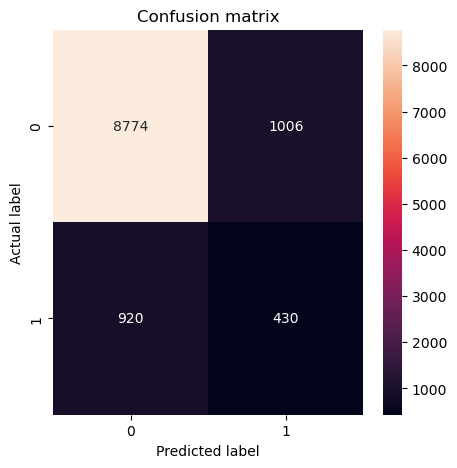

In [735]:
best_models =  {'model_0': 'dt',
 'model_1': 'rf_uo',
 'model_2': 'xgb',
 'model_3': 'cb',
 'model_4': 'cb',
 'model_5': 'dt_uo',
 'model_6': 'bag'}

super_model = SuperLearner(2, model_features)

for i in best_models:
        super_model.add_model(models[best_models[i]], best_models[i])

super_model.add_meta_model(clone(models['dt_uo']))

meta_X, meta_y = super_model.get_out_of_fold_predictions(train, y_train)
super_model.fit_base_models(train, y_train, lgbm_params, xgb_params)
super_model.fit_meta_model(meta_X, meta_y)
y_prob = super_model.super_learner_predict(test)

tau = 1/20

y_prob = y_prob[:, -1]
y_prob[y_prob < 1e-5] = 1e-5
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob > 1/20).astype(int)
plot_cm(y_test, y_pred)

In [738]:
f1_score(y_test, y_prob)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

0.6078277664167234
(True Negatives):  8774
(False Positives):  1006
(False Negatives):  920
(True Positives):  430
Total subscribed Transactions:  1350


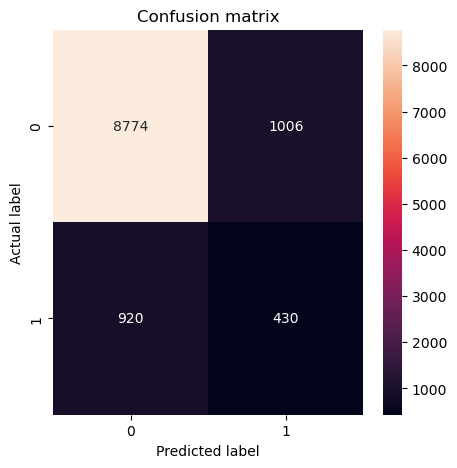

In [737]:
y_pred = (y_prob > 1/20).astype(int)
plot_cm(y_test, y_pred)

In [ ]:
print(roc_auc_score(y_test, y_prob))

In [699]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

results = pd.DataFrame(0.0, columns=columns, index=["Model stack"])

results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
results.iloc[:,6] =  f1_score(y_test, y_pred)

In [700]:
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Model stack,0.28667,0.57826,0.80308,0.91037,0.35429,0.16291


In [42]:
best_models2 =   {'model_0': 'lr',
 'model_1': 'lgbm',
 'model_2': 'cb',
 'model_4': 'bag_uo',
 'model_6': 'rf_uo',
 'model_9': 'dt_uo',
 'model_10': 'xgb'}

super_model = SuperLearner(6, model_features)

for i in best_models2:
        super_model.add_model(models[best_models2[i]], best_models2[i])

super_model.add_meta_model(clone(models['gb']))

meta_X, meta_y = super_model.get_out_of_fold_predictions(train, y_train)
super_model.fit_base_models(train, y_train, lgbm_params, xgb_params)
super_model.fit_meta_model(meta_X, meta_y)
y_prob = super_model.super_learner_predict(test)


[    1     2     3 ... 20771 20772 20773]
[    0     4     5 ... 20771 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20772 20773 20774]
[    0     1     2 ... 20770 20772 20774]
training features: lr, shape: (20775, 35), ['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
training features: lgbm, shape: (20775, 47), ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'education

In [43]:
y_prob, y_pred = super_model.super_learner_predict(test)
y_prob

lr
['default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'contact_cellular', 'contact_telephone', 'previous', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'jobGLMM', 'maritalGLMM', 'educationGLMM', 'day_of_weekGLMM', 'age', 'emp_var_rate', 'cons_price_idxLog', 'cons_conf_idx', 'euribor_3mLog', 'nr_employedLog']
lgbm
['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 

array([[0.53668111, 0.46331889],
       [0.93343019, 0.06656981],
       [0.9570822 , 0.0429178 ],
       ...,
       [0.93594541, 0.06405459],
       [0.95534036, 0.04465964],
       [0.96356734, 0.03643266]])

0.7995014390668788
0.6480743012951602
(True Negatives):  3983
(False Positives):  5797
(False Negatives):  150
(True Positives):  1200
Total subscribed Transactions:  1350


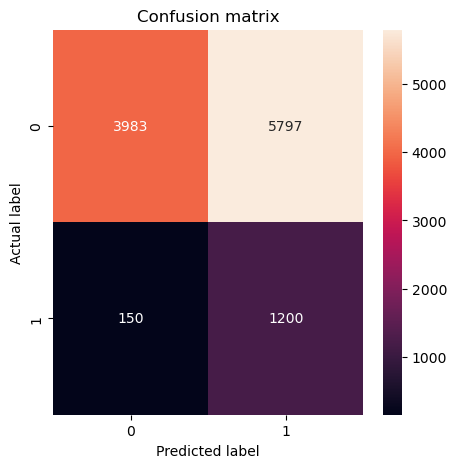

In [44]:

tau = 1/20

y_prob = y_prob[:, -1]
y_prob[y_prob < 1e-5] = 1e-5
y_prob[y_prob > 1- 1e-5] =  1- 1e-5
print(roc_auc_score(y_test, y_prob))
y_pred = (y_prob > tau).astype(int)
plot_cm(y_test, y_pred)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

results = pd.DataFrame(0.0, columns=columns, index=["Model stack"])

results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
results.iloc[:,6] =  f1_score(y_test, y_pred)

In [46]:
display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Model stack,0.28728,0.53432,0.7995,0.88889,0.40726,0.1715,0.28753


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Model stack,0.29058,0.60368,0.80482,0.92,0.32403,0.15816
